In [76]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
# from ipynb.fs.full.preProcess import basic_preProcess, category_preProcess, color_preProcess

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate

In [77]:
def basic_preProcess(img):
    img = resize_image(img)
    return img

def resize_image(img):
  image_size = (224,224)
  img = cv.resize(img, image_size,interpolation = cv.INTER_LINEAR)
  return img

def color_preProcess(img):
  #insert methods
  return img

def to_colorhsv(img):

  hue_shift = 180
  saturation_scale = 2
  value_scale = 5

  img[..., 1] = np.clip(img[..., 1] * saturation_scale, 0, 255)
  img[..., 2] = np.clip(img[..., 2] * value_scale, 0, 255)
  img[..., 2] = cv.equalizeHist(img[..., 2])

  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)

  return img

def to_CIELAB(img):
  img = cv.cvtColor(img,cv.COLOR_BGR2Lab)
  return img

def to_CIEXYZ(img):
  img = cv.cvtColor(img,cv.COLOR_BGR2XYZ)
  return img

def to_RGB(img):
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  return img

def category_preProcess(img):
  img = to_grayhsv(img)

  return img

def to_grayhsv(img):

  saturation_scale = 0
  value_scale = 0.1

  img[..., 1] = np.clip(img[..., 1] * saturation_scale, 0, 255)
  img[..., 2] = np.clip(img[..., 2] * value_scale, 0, 255)
  img[..., 2] = cv.equalizeHist(img[..., 2])

  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
  return img

def gamma_correct_HSV(img):

  gamma = 2.0

  hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  H, S, V = cv.split(hsv_img)

  lookup_table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255 for i in np.arange(0, 256)]).astype("uint8")

  V_corrected = cv.LUT(V, lookup_table)
  corrected_hsv = cv.merge([H, S, V_corrected])
  corrected_image = cv.cvtColor(corrected_hsv, cv.COLOR_HSV2BGR)

  return corrected_image

In [78]:
# For Local File:
train_dir = './train/'
test_dir = './test/'
train_df = pd.read_csv('./train.csv')

In [79]:
train_data_color = []
train_data_category = []

train_jenis = []
train_warna =[]

test_data = []
test_ids = []

train_shapes = []
test_shapes = []

input_shape = (224, 224, 3)
for i in os.listdir(train_dir):
    if(i is not None):
        img_path = os.path.join(train_dir, i)
        img = cv.imread(img_path)
        if(img is not None):

          h,w = img.shape[:2]
          train_shapes.append((h,w))
          img = basic_preProcess(img)
          img_category = category_preProcess(img)
          # img_color = color_preProcess(img)
          img_color = img
          # plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
          # plt.show()
          # break
          train_data_color.append(img_color)
          train_data_category.append(img_category)

          cond = train_df['id'] == int(i[:-4])
          idx = train_df.loc[cond].index[0]
          train_jenis.append(train_df.iloc[idx]['jenis'])
          train_warna.append(train_df.iloc[idx]['warna'])

        else:
          print("no image found")

for i in os.listdir(test_dir):
    if(i is not None):
      img_path = os.path.join(test_dir, i)
      img = cv.imread(img_path)
      if(img is not None):
        h,w = img.shape[:2]
        test_shapes.append((h,w))
        img = basic_preProcess(img)
        test_data.append(img)
        test_ids.append(i[:-4])
      else:
        print("no image found")

xtrain_warna, xval_warna, ytrain_warna, yval_warna = train_test_split(
    train_data_color, train_warna,
    test_size=0.2, random_state=42,
    stratify=train_warna  # Ensures balanced class distribution for color labels
)

xtrain_jenis, xval_jenis, ytrain_jenis, yval_jenis = train_test_split(
    train_data_category, train_jenis,
    test_size=0.2, random_state=42,
    stratify=train_jenis  # Ensures balanced class distribution for category labels
)

In [80]:
print(len(train_df))
print("================")
print(train_df.describe())
print("================")
print(train_df.dtypes)
print("================")
print(train_df.isna().sum())
print("================")
print("duplicated : ",train_df.duplicated().sum())

777
               id       jenis       warna
count  777.000000  777.000000  777.000000
mean   389.000000    0.387387    2.202059
std    224.444871    0.487467    1.319597
min      1.000000    0.000000    0.000000
25%    195.000000    0.000000    1.000000
50%    389.000000    0.000000    2.000000
75%    583.000000    1.000000    3.000000
max    777.000000    1.000000    4.000000
id       int64
jenis    int64
warna    int64
dtype: object
id       0
jenis    0
warna    0
dtype: int64
duplicated :  0


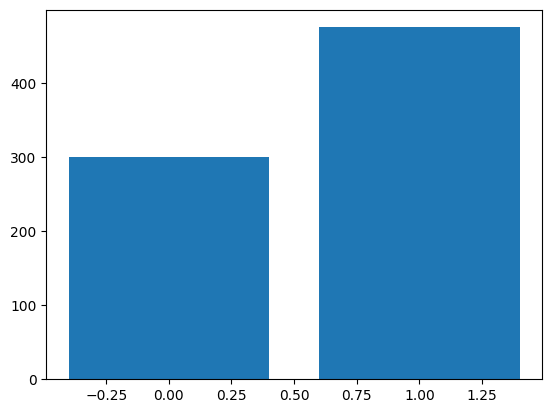

jenis
0    476
1    301
Name: count, dtype: int64

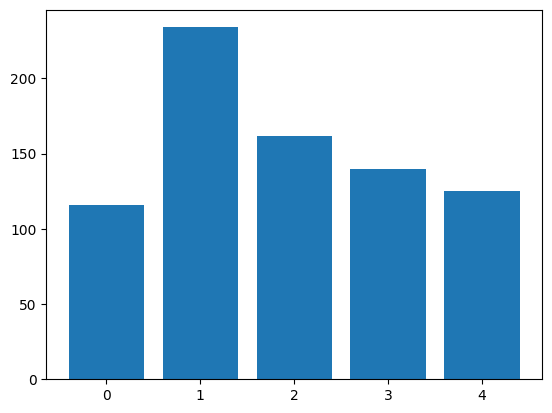

warna
3    234
2    162
4    140
1    125
0    116
Name: count, dtype: int64


In [81]:
jenisWarna_df = train_df[['jenis','warna']]
plt.bar(jenisWarna_df['jenis'].unique(),jenisWarna_df['jenis'].value_counts())
plt.show()
display(jenisWarna_df['jenis'].value_counts())
plt.bar(jenisWarna_df['warna'].unique(),jenisWarna_df['warna'].value_counts())
plt.show()
print(jenisWarna_df['warna'].value_counts())

In [82]:
print(train_shapes)
print(test_shapes)

[(200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (20

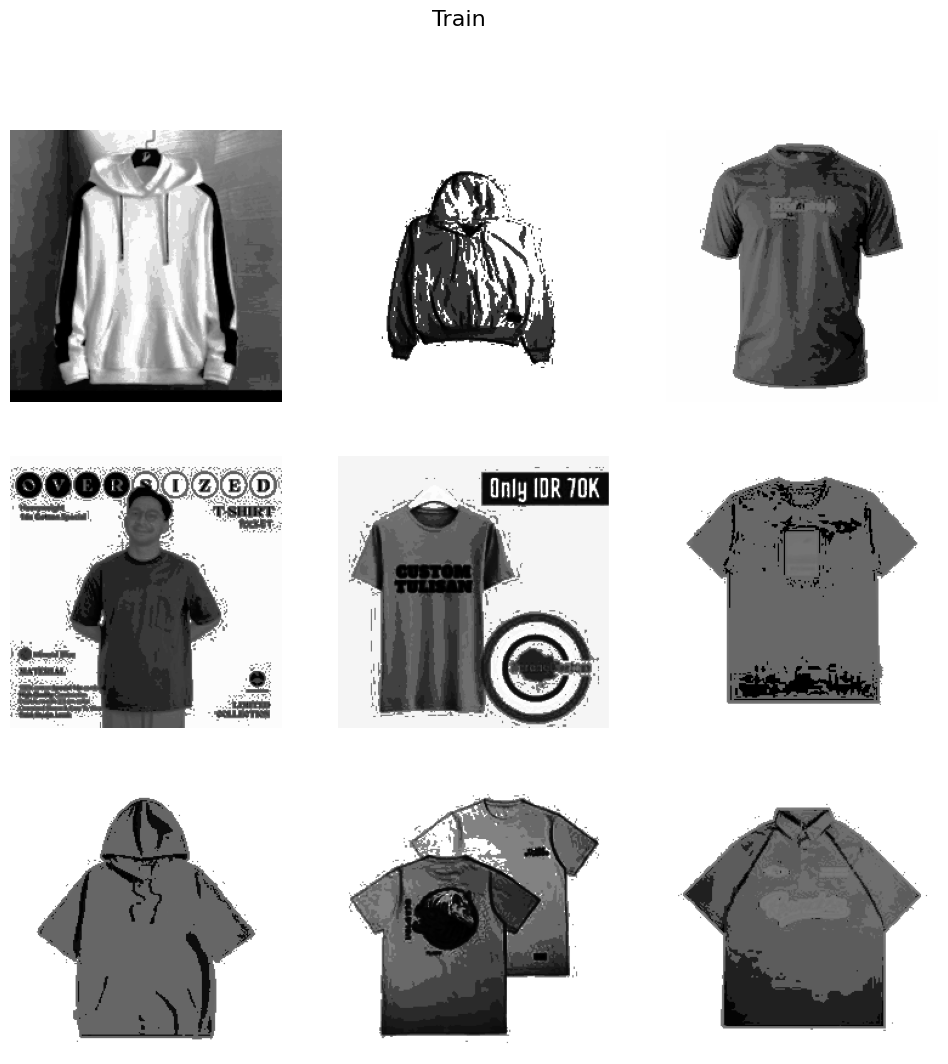

In [83]:
sample_images = np.random.choice(len(train_data_category), size=9, replace=False)
plt.figure(figsize=(12, 12))
for idx, curr in enumerate(sample_images, start=1):
    img = train_data_category[curr]
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

    plt.subplot(3, 3, idx)
    plt.imshow(img)
    plt.axis('off')
    # plt.title(os.path.basename(img_path))
plt.suptitle("Train", fontsize=16)
plt.show()

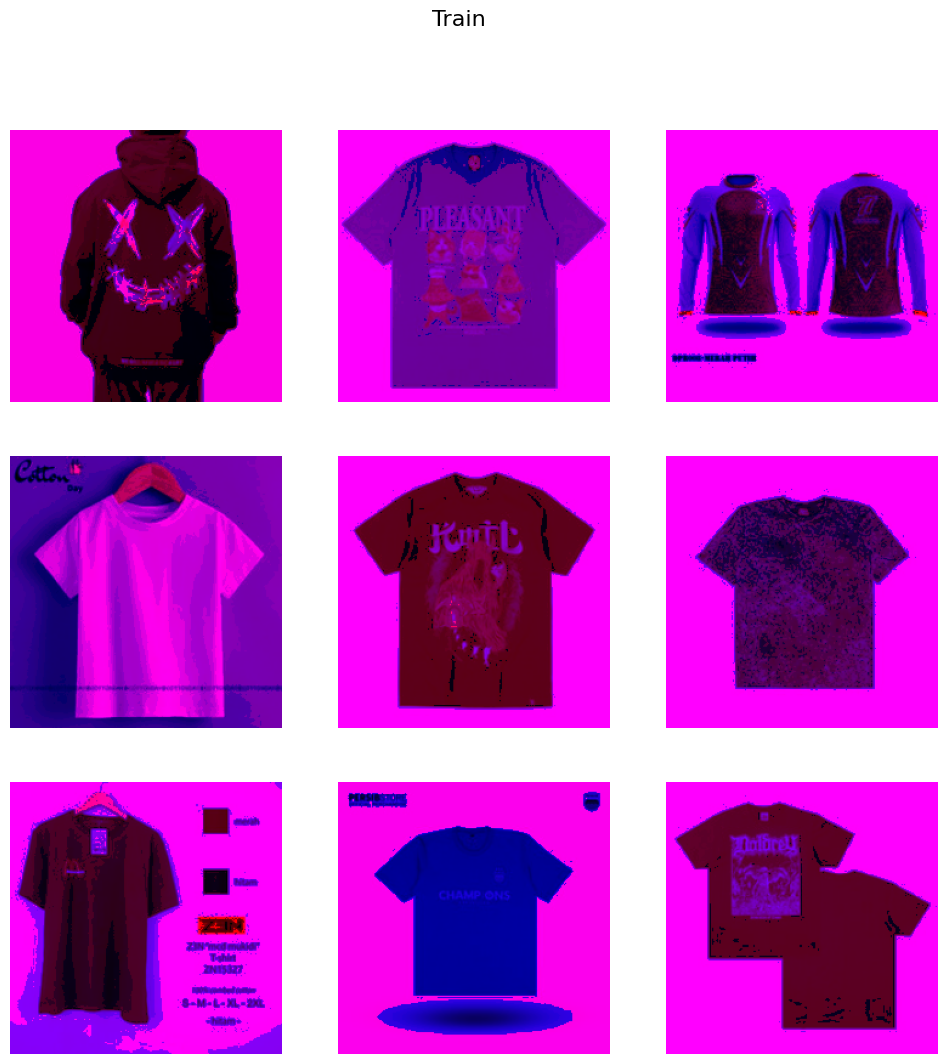

In [84]:
sample_images = np.random.choice(len(train_data_color), size=9, replace=False)
plt.figure(figsize=(12, 12))
for idx, curr in enumerate(sample_images, start=1):
    img = train_data_color[curr]
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.subplot(3, 3, idx)
    plt.imshow(img)
    plt.axis('off')
    # plt.title(os.path.basename(img_path))
plt.suptitle("Train", fontsize=16)
plt.show()